# Change in exposure to heatwaves

Heat waves are defined here using the index proposed in Jacob et al. [2013] (but using daily minimum temperature data instead of maximum), as any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005). The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).
  
The heatwave risk Hˆ is then measured as the change in heatwave frequency
∆H multiplied by the population;

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.


## Method

Want to avoid having to loop over every time series.


1. Calculate daily min and save
2. Select period of interest (2000-2015)
3. Set all values < 99% percentile threshold to nan/fill value, leaving only heatwave sequences
4. Compare Equality array against itself offset by 1 in time dimension - v(t) == v(t-1). This will set all sequence start/ends to False, and all points inside or outside sequence to true
5. Invert the array and conver to int, so that all start/ends =1 and all other  = 0
6. Sum array in time dimension and divide by 2 => will be sum of sequences

TODO => This will include sequences of length >1, need to figure out how to restrict to >3



In [3]:
%matplotlib inline
import numpy as np
import xarray as xr

from config import DATA_SRC

In [4]:

t_min_file = DATA_SRC / 'weather' / 'ecmwf' / 'era_interim_temperature_day_min.nc'
high_t_reference_file = DATA_SRC / 'lancet' / 'heatwave_high_t_reference.nc'

### Load weather data and save minimas

NOTE: only need to do this once

In [15]:
weather_file = DATA_SRC / 'weather' / 'ecmwf' / 'era_interim_temperature_2m.nc'
era_alltemps = xr.open_dataset(str(weather_file), chunks={'time': 24})
era_allmin = era_alltemps.resample('1D', dim='time', how='min')
era_allmin.to_netcdf(str(t_min_file))

In [17]:
era_alltemps.close()

### Open the saved minimas file

In [5]:
era_allmin = xr.open_dataset(str(t_min_file), chunks={'time': 24})

## Calculate the 99th percentile 1986-2005

In [21]:
recent_past = era_allmin.sel(time=slice('1986-01-01', '2005-12-31'))
high_t_reference = recent_past.quantile(0.99, dim='time')

In [25]:
high_t_reference.to_netcdf(str(high_t_reference_file))

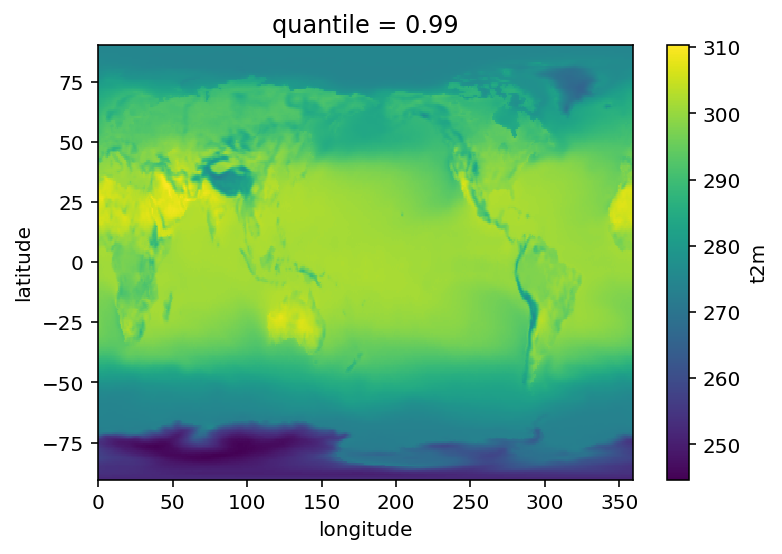

In [31]:
high_t_reference.t2m.plot()

### Load the high-t reference file

In [6]:
high_t_reference = xr.open_dataset(str(high_t_reference_file))

## For period of interest, mask the arry keeping only t > tref

In [7]:
# Restrict to period of interest
era_allmin = era_allmin.sel(time=slice('2000-01-01', '2015-12-31'))

### TODO check this. Think that by taking the mean over 4 days, periods of 3 or less days will drop below the threshold and vanish. NOTE I think for this to work, need to first threshold and replace all values with 0 or something very negative to ensure that if you have e.g. 2 extremely high days with normal days either side, the mean might still be over the threshold. Otherwise, basically wherever the window overlaps a heatwave edge the mean will drop and the value vanish. For heatwave of exactly 4 days, only one day in the centre will trigger the heatwave and be counted.

### Caveat - might get something funny with heatwaves with 1/2/3 days beween them. This is where setting -9999 instead of 0 would be best...

In [25]:
# First take threshold and replace vals below so that rolling mean does it's thing
# era_allmin = era_allmin.where(era_allmin.t2m >= high_t_reference.t2m)

In [8]:
# Replace nan's by zero so that rolling mean should be sure to drop val below threshold.
# Might be better to replace with -9999, must be np func for that
# era_allmin.t2m.values = np.nan_to_num(era_allmin.t2m)

In [10]:
# For now have to call load, rolling dask ops not implemented
# era_allmin = era_allmin.load()
# era_allmin = era_allmin.rolling(time=4).mean()

In [8]:
# Take the threshold after the mean is applied
era_allmin = era_allmin.where(era_allmin.t2m >= high_t_reference.t2m)

## rolling doesn't seem to work great. How about bool only. filter where, then do isfinite so True in highT False else. Then collapse it (maybe bool AND 4x?) to keep only cases where at least 4 sequential instances of true.

In [25]:
heatwaves = xr.ufuncs.isfinite(era_allmin.t2m)

In [26]:
heatwaves = xr.ufuncs.logical_and(
    xr.ufuncs.logical_and(xr.ufuncs.logical_and(heatwaves,
                                                heatwaves.shift(time=-1)),
                          xr.ufuncs.logical_and(heatwaves.shift(time=-1), 
                                                heatwaves.shift(time=-2))),
    xr.ufuncs.logical_and(xr.ufuncs.logical_and(heatwaves.shift(time=-1),
                                                heatwaves.shift(time=-2)),
                          xr.ufuncs.logical_and(heatwaves.shift(time=-2), 
                                                heatwaves.shift(time=-3))))


# & heatwaves.shift(time=-2) & heatwaves.shift(time=-3)

In [27]:
heatwaves = heatwaves != heatwaves.shift(time=-1)
# heatwaves = xr.ufuncs.logical_not(heatwaves)
heatwaves = heatwaves.astype(np.int32)

In [30]:
# northern hemisphere
lat_north = heatwaves.latitude[heatwaves.latitude >= 0]
lat_south = heatwaves.latitude[heatwaves.latitude < 0]

# Summer North
summer_jja = heatwaves['time.season'] == 'JJA'
# Summer South
summer_djf = heatwaves['time.season'] == 'DJF'


# Sum summer north and south div by 2 to get the right N
nh = heatwaves.sel(time=summer_jja).groupby('time.year').sum(dim='time') / 2
sh = heatwaves.sel(time=summer_djf).groupby('time.year').sum(dim='time') / 2



In [31]:
heatwaves = xr.concat([nh.sel(latitude=lat_north),  
                         sh.sel(latitude=lat_south)], dim='latitude')



/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/async.py:247: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


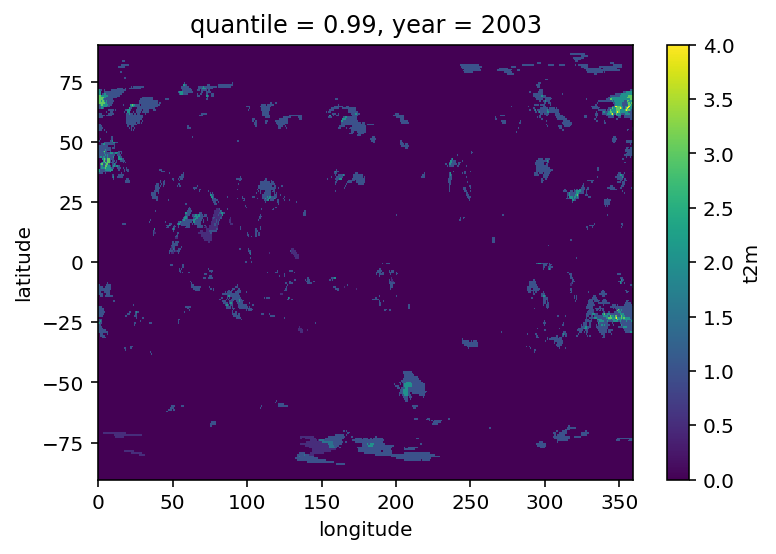

In [33]:
heatwaves.sel(year=2003).plot()